<a href="https://colab.research.google.com/github/MShiloni22/DDBMS_Project_B/blob/master/DDBMS_Project_B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pyspark
!pip install findspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 42 kB/s 
     |████████████████████████████████| 199 kB 52.8 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=b1e2dc06104d884b5b83999077f93a3c8306be6b68ad688e726fc67dde78cf5e
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import findspark
import datetime as dt

findspark.init()
from pyspark.sql import SparkSession
def init_spark(app_name: str):
 spark = SparkSession.builder.appName(app_name).getOrCreate()
 sc = spark.sparkContext
 return spark, sc
spark, sc = init_spark('demo')
sc

<SparkContext master=local[*] appName=demo>

+-------------+-------------------+--------+-----+------+----+-----+-------------+-------------+-------------+------------+-----------+----------+-----+
| Arrival_Time|      Creation_Time|  Device|Index| Model|User|   gt|            x|            y|            z|Device_index|Model_index|User_index|label|
+-------------+-------------------+--------+-----+------+----+-----+-------------+-------------+-------------+------------+-----------+----------+-----+
|1424686735175|1424686733176178965|nexus4_1|   35|nexus4|   g|stand| 0.0014038086|    5.0354E-4|-0.0124053955|         1.0|        0.0|       3.0|  2.0|
|1424686735378|1424686733382813486|nexus4_1|   76|nexus4|   g|stand|-0.0039367676|  0.026138306|  -0.01133728|         1.0|        0.0|       3.0|  2.0|
|1424686735577|1424686733579072031|nexus4_1|  115|nexus4|   g|stand|  0.003540039| -0.034744263| -0.019882202|         1.0|        0.0|       3.0|  2.0|
|1424686735779|1424688581834321412|nexus4_2|  163|nexus4|   g|stand|  0.002822876|

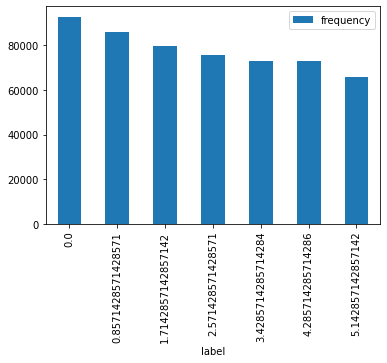

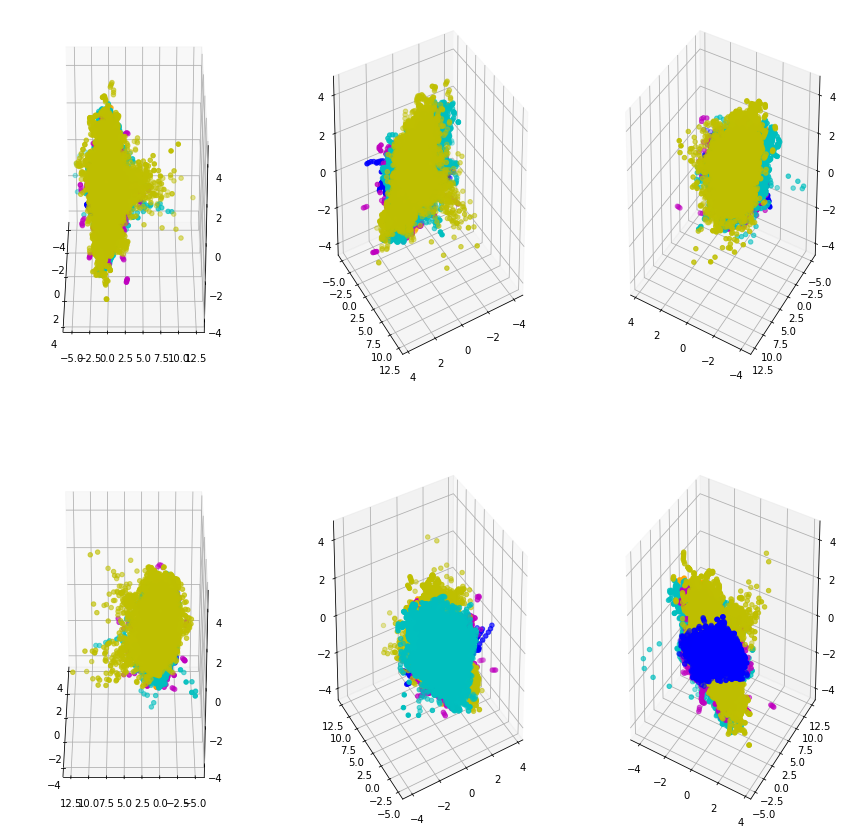

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2cd200be10>,
      dtype=object)

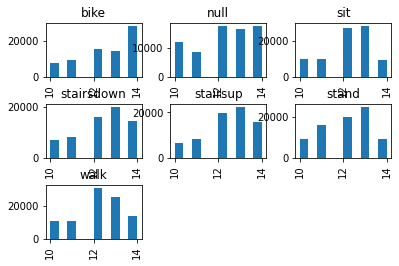

In [ ]:
# Section 1 - Data Analysis
import pandas as pd
import pyspark.sql as sparksql
from pyspark.ml.feature import StringIndexer
import pyspark.sql.functions as F
from pandas import DataFrame
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import datetime

# Read JSON file into dataframe
df = spark.read.json("/content/drive/MyDrive/Colab Files/DDBMS/data.json")

# convert categorical values of 'gt' to indices
indexer = StringIndexer(
  inputCols=["Device", "Model", "User", "gt"],
  outputCols=["Device_index", "Model_index", "User_index", "label"])
model = indexer.fit(df)
df = model.transform(df)
df.show()

## insight 1 - histogram of gt values and their propotion ##
# creating hist in spark df
gt_histogram = df.select('label').rdd.flatMap(lambda x: x).histogram(7)

# convert hist to pandas, in order to plot
pd.DataFrame(
    list(zip(*gt_histogram)), 
    columns=['label', 'frequency']
).set_index(
    'label'
).plot(kind='bar')
# Insight 1:
# We can see that the different clusters of activities are balanced, more or less
# Therefore, we can avoid scaling weighting when we approach the label classification

## insight 2 - can arrival\creation time can be ignored? ##
# convert creation_time to arrival's format
df = df.withColumn("arrival_creation_diff",
                   (F.col("Arrival_Time") - (F.col("Creation_Time")/1000000))**2)
df.show()
	
# mean and variance value of the column in pyspark
df.agg({'arrival_creation_diff': 'mean'}).show()
df.agg({'arrival_creation_diff': 'variance'}).show()
# Insight 2:
# the mean difference between creation and arrival time is approximately 1 second
# the variance is approx. 1 second
# therefore, we can ignore one of these columns in the ML process, we chose
# to continue with Arrival_Time

## insight 3 - Is the data linear seperated, via visualization ##
# convert df to pandas's df for conviency
points_df = df.select(["x", "y", "z", "label"])
pd_points_df = points_df.toPandas()

# visualize 3d plot
colors = {0 : 'orange', 1:'g', 2: 'r', 3: 'b', 4: 'c', 5: 'm', 6: 'y'}
fig, axs = plt.subplots(2, 3, subplot_kw=dict(projection="3d"), figsize=(15,15))
angle_1 = 0
for i in range(2):
  for j in range(3):
    for l in pd_points_df['label'].unique():
      axs[i, j].view_init(30, angle_1)
      axs[i, j].scatter(xs = pd_points_df.loc[pd_points_df.label == l, 'x'], 
                ys = pd_points_df.loc[pd_points_df.label == l, 'y'],
                zs = pd_points_df.loc[pd_points_df.label == l, 'z'], 
                color = colors[l])
      angle_1 += 60

plt.show()
# Insight 3:
# although linear seperability cannot be strongly assumed by the data visualizations,
# we think that (x, y, z) values can contribute to predict data's label

## insight 4 - labels in different hours ##
# create new column, contains 'Arrival_Time' in datetime format
datetime_df = df.select(["Arrival_Time", "gt"]).toPandas()
datetime_df["Arrival_Time"] = datetime_df["Arrival_Time"]\
  .apply(lambda row: datetime.datetime.fromtimestamp(row//1000))
datetime_df["hour"] = datetime_df["Arrival_Time"]\
  .apply(lambda row: row.hour)

# create histogram of labels according to hours
datetime_df.hist(column="hour", by="gt")
# Insigt 4:
# the hour the sensor sent the record isn't strong enough to predict label




In [ ]:
# Section 2 - Learning Task
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression

## data pre-processing: dummy all categorical features, normalize all numerical features
# normalize numerical features
# collect min and max for each numerical column
numerical_columns = ["Arrival_Time", "x", "y", "z"]
for c in numerical_columns:
  min = df.agg({f"{c}": "min"}).collect()[0][f"min({c})"]
  max = df.agg({f"{c}": "max"}).collect()[0][f"max({c})"]
  # normalization
  df = df.withColumn(c+"_normalized", (df[c] - min)/(max - min))

df = df.withColumn("Device_dummy", (df.Device == "nexus4_1").cast('double'))
letters = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i']
for l in letters:
  df = df.withColumn("User_"+l, (df.User == l).cast('double'))

# drop irrelevant columns
# add in pdf reason why we dropped these cloumns
irrelevant_columns = ("Creation_Time", "Index", "Model", "Device_index",
                      "Model_index", "User_index", "gt", "arrival_creation_diff",
                      "Arrival_Time", "x", "y", "z", "Device", "User")
df = df.drop(*irrelevant_columns)

# create vector for each row, together with dummy values
assembler = VectorAssembler(
    inputCols=df.columns[1:], outputCol="features")

prepared_df = assembler.transform(df)
prepared_df.show()

# remove irrelevant columns, remain only features and labels
ml_df = prepared_df.select(["features", "label"])

# split train and test - 70%-30% propotion
train, test = ml_df.randomSplit([0.7, 0.3], seed=12345)

## logistic regression ##
lr = LogisticRegression()
lrModel = lr.fit(train)
lrTestPredict = lrModel.transform(test)\
    .select("features", "label", "prediction")
lrTestPredict = lrTestPredict.withColumn("LabEqPred",
                                         (lrTestPredict.label == lrTestPredict.prediction)\
                                         .cast('double'))
test_accuracy = (lrTestPredict.groupBy().sum().collect()[0][2])/lrTestPredict.count()
print(f"test accuracy = {test_accuracy}")

+-----+-----------------------+------------------+-------------------+-------------------+------------+------+------+------+------+------+------+------+------+------+--------------------+
|label|Arrival_Time_normalized|      x_normalized|       y_normalized|       z_normalized|Device_dummy|User_a|User_b|User_c|User_d|User_e|User_f|User_g|User_h|User_i|            features|
+-----+-----------------------+------------------+-------------------+-------------------+------------+------+------+------+------+------+------+------+------+------+--------------------+
|  2.0|   2.112422893278945E-6|0.5203237773683166|0.28850054443420337| 0.4794956505032828|         1.0|   0.0|   0.0|   0.0|   0.0|   0.0|   0.0|   1.0|   0.0|   0.0|(14,[0,1,2,3,4,11...|
|  2.0|    4.08856043860441E-6|0.5196508686811572| 0.2899770417688004|0.47962284879209344|         1.0|   0.0|   0.0|   0.0|   0.0|   0.0|   0.0|   1.0|   0.0|   0.0|(14,[0,1,2,3,4,11...|
|  2.0|   6.025759313086023E-6|0.5205929408331003|0.28647036

In [ ]:
# Section 2 cont.
from pyspark.ml.classification import LogisticRegression

# remove irrelevant columns, remain only features and labels
ml_df = prepared_df.select(["features", "label"])

# split train and test - 70%-30% propotion
train, test = ml_df.randomSplit([0.7, 0.3], seed=12345)

## logistic regression ##
lr = LogisticRegression()
lrModel = lr.fit(train)
lrTestPredict = lrModel.transform(test)\
    .select("features", "label", "prediction")
lrTestPredict = lrTestPredict.withColumn("LabEqPred",
                                         (lrTestPredict.label == lrTestPredict.prediction)\
                                         .cast('double'))
test_accuracy = (lrTestPredict.groupBy().sum().collect()[0][2])/lrTestPredict.count()
print(f"test accuracy = {test_accuracy}")


test accuracy = 0.6758334248179456
